In [2]:
import outlines
import polars as pl
from PIL import Image
import io
from datasets import load_dataset

C:\Users\zelaw\PycharmProjects\Kaggle_Gym\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_image(image : bytes):
    image_stream = io.BytesIO(df["image"][0]['bytes'])
    return Image.open(image_stream)

In [4]:
# Load dataset with Hugging Face
hf_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
print(hf_dataset[0].keys())

dict_keys(['image', 'ground_truth'])


In [5]:
type(hf_dataset)

datasets.arrow_dataset.Dataset

In [6]:
# # Convert to Polars DataFrame
df = pl.DataFrame(hf_dataset.to_list())

In [7]:
df.head()

image,ground_truth
struct[2],str
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01\\xc1[\xb3m\xeby\x15\xe6\xd6\xda\xfb\xf5>\xc6\x98s""…,null}","""{""gt_parse"": {""menu"": [{""nm"": …"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01$\xc1\xc1\xd2d]\x92\x1d\xd4\xbd\xdd\xfd\x9c{#\xbe\xfc""…,null}","""{""gt_parse"": {""menu"": [{""nm"": …"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x02\xd0\x00\x00\x05\x00\x08\x02\x00\x00\x00\xe1\xac\xf2j\x00\x00\x20\x00IDATx\x01\xec\xc1\xedr\x1cGb(\xd1\xcc\xc2\x87\xf6\xbd\xd7\xd6\x0f""…,null}","""{""gt_parse"": {""menu"": [{""nm"": …"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x04T\x00\x00\x05\xc6\x08\x02\x00\x00\x00!Fl\xfb\x00\x00\x20\x00IDATx\x01d\xc1\x01\x8edI\x92$V\x11U\xb3\xef\x1e\x91\xd9\xd9""…,null}","""{""gt_parse"": {""menu"": [{""nm"": …"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01\xa4\xc1\x0b\x12,\xc9\x95\x1cV\xffD\xd6\xc3\xcc\xfe\x17@""…,null}","""{""gt_parse"": {""menu"": {""nm"": ""…"


In [8]:
df[:"image"]

image
struct[2]
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01\\xc1[\xb3m\xeby\x15\xe6\xd6\xda\xfb\xf5>\xc6\x98s""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01$\xc1\xc1\xd2d]\x92\x1d\xd4\xbd\xdd\xfd\x9c{#\xbe\xfc""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x02\xd0\x00\x00\x05\x00\x08\x02\x00\x00\x00\xe1\xac\xf2j\x00\x00\x20\x00IDATx\x01\xec\xc1\xedr\x1cGb(\xd1\xcc\xc2\x87\xf6\xbd\xd7\xd6\x0f""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x04T\x00\x00\x05\xc6\x08\x02\x00\x00\x00!Fl\xfb\x00\x00\x20\x00IDATx\x01d\xc1\x01\x8edI\x92$V\x11U\xb3\xef\x1e\x91\xd9\xd9""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01\xa4\xc1\x0b\x12,\xc9\x95\x1cV\xffD\xd6\xc3\xcc\xfe\x17@""…,null}"
…
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x09\x00\x00\x00\x10\x00\x08\x02\x00\x00\x00\xa8zI\x0e\x00\x00\x20\x00IDATx\x01\xc4\xc1\xcb\xaem\xd9\x95.\xe4\xffo\xad\xf7>\xe6e\xad""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x03`\x00\x00\x05\x10\x08\x02\x00\x00\x00\xad\x02\xa4\x08\x00\x00\x20\x00IDATx\x01\x1c\xc1Y\xcf\xa5\xc9\x96\x18\xe4\x15+\xe6x\xa7\xbd\xbf!""…,null}"
"{b""\x89PNG\x0d\x0a\x1a\x0a\x00\x00\x00\x0dIHDR\x00\x00\x02@\x00\x00\x03`\x08\x02\x00\x00\x00K#@\xe3\x00\x00\x20\x00IDATx\x014\xc1\xeb\xae,\xc9v\x1e\xd6o^""""3\xab\xd6\xee""…,null}"


In [9]:
import matplotlib.pyplot as plt
import json

In [10]:
sample_reciept = load_image(df[0]["image"])

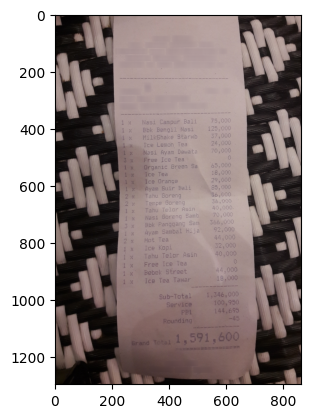

In [11]:
plt.imshow(sample_reciept)

In [12]:
data = df[0]["ground_truth"].to_list()
print(len(data), type(data))

1 <class 'list'>


In [13]:
import pytesseract

text = pytesseract.image_to_string(sample_reciept)
print(text)

In [14]:
from transformers import AutoModel
model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")

In [15]:
model?

Signature:      model(*args, **kwargs)
Type:           LayoutLMv3Model
String form:   
LayoutLMv3Model(
           (embeddings): LayoutLMv3TextEmbeddings(
           (word_embeddings): Embedding(50265 <...> s=12, bias=False)
           (rel_pos_y_bias): Linear(in_features=64, out_features=12, bias=False)
           )
           )
File:           c:\users\zelaw\pycharmprojects\kaggle_gym\.venv\lib\site-packages\transformers\models\layoutlmv3\modeling_layoutlmv3.py
Docstring:     
The bare Layoutlmv3 Model outputting raw hidden-states without any specific head on top.

This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
etc.)

This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
Use it as a regular PyTorch Module and refer to the PyTorch documentation for all 

In [18]:
from torchinfo import summary

summary(
    model=model
)

Layer (type:depth-idx)                                  Param #
LayoutLMv3Model                                         152,064
├─LayoutLMv3TextEmbeddings: 1-1                         --
│    └─Embedding: 2-1                                   38,603,520
│    └─Embedding: 2-2                                   768
│    └─LayerNorm: 2-3                                   1,536
│    └─Dropout: 2-4                                     --
│    └─Embedding: 2-5                                   394,752
│    └─Embedding: 2-6                                   131,072
│    └─Embedding: 2-7                                   131,072
│    └─Embedding: 2-8                                   131,072
│    └─Embedding: 2-9                                   131,072
├─LayoutLMv3PatchEmbeddings: 1-2                        --
│    └─Conv2d: 2-10                                     590,592
├─Dropout: 1-3                                          --
├─LayerNorm: 1-4                                        1,536
├

In [19]:
model.embeddings

LayoutLMv3TextEmbeddings(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (x_position_embeddings): Embedding(1024, 128)
  (y_position_embeddings): Embedding(1024, 128)
  (h_position_embeddings): Embedding(1024, 128)
  (w_position_embeddings): Embedding(1024, 128)
)

In [21]:
model.encoder

LayoutLMv3Encoder(
  (layer): ModuleList(
    (0-11): 12 x LayoutLMv3Layer(
      (attention): LayoutLMv3Attention(
        (self): LayoutLMv3SelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): LayoutLMv3SelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): LayoutLMv3Intermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): LayoutLMv3Output(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((